## Import Libraries

In [1]:
# read hdf5 file and plot the data
import h5py
import xmltodict
import numpy as np
import pandas as pd
import mne
import matplotlib.pyplot as plt
import plotly.express as px
# raise SystemExit("Stop Point!")

## Load Data

In [2]:
# read the file
datafile_path = "../../data/"
filename = datafile_path + "RH ERD2024.03.11_12.52.32.hdf5"
# filename = datafile_path + "imagine hand2024.03.07_11.23.45.hdf5" 
# filename = datafile_path + "neck movement bottom right2024.03.01_10.43.37.hdf5"
# filename = datafile_path + "neck movement bottom left2024.03.01_10.53.24.hdf5"
# filename = datafile_path + "hand clench2024.03.07_11.30.28.hdf5"

def read_hdf5(filename):
    with h5py.File(filename, "r") as FILE:
        # Print all root level object names (aka keys) 
        # these can be group or dataset names 
        print("Keys: %s" % FILE.keys())

        # List all the groups in the file
        print("\nGroups in the HDF5 file:")
        print(list(FILE.keys()))

        # Print all the groups and datasets
        print("\nGroups and datasets in the HDF5 file:")
        for key in FILE.keys():
            print(key, FILE[key])
        # Print al the datasets in the RawData group
        print("\nDatasets in the RawData group:")
        print(list(FILE['RawData'].keys()))
        # Print al the datasets in the AsynchronData group
        print("\nDatasets in the AsynchronData group:")
        print(list(FILE['AsynchronData'].keys()))

        # Access a specific group
        data_samples = FILE['RawData']['Samples'][:]
        data_asynchron_times = FILE['AsynchronData']['Time'][:]
        data_task_description = FILE['RawData']['AcquisitionTaskDescription'][:]
        # data_info[0] is a xml format string, convert it to to dictionary using xmltodict
        data_info_dict = xmltodict.parse(data_task_description[0])
        FILE.close()
        return data_samples, data_asynchron_times, data_info_dict
    
data_samples, data_asynchron_times, data_info_dict = read_hdf5(filename)

Keys: <KeysViewHDF5 ['AsynchronData', 'RawData', 'SavedFeatues', 'Version']>

Groups in the HDF5 file:
['AsynchronData', 'RawData', 'SavedFeatues', 'Version']

Groups and datasets in the HDF5 file:
AsynchronData <HDF5 group "/AsynchronData" (4 members)>
RawData <HDF5 group "/RawData" (7 members)>
SavedFeatues <HDF5 group "/SavedFeatues" (1 members)>
Version <HDF5 group "/Version" (1 members)>

Datasets in the RawData group:
['AcquisitionTaskDescription', 'DAQDeviceCapabilities', 'DAQDeviceDescription', 'ElectrodeMontageDefinition', 'Samples', 'SessionDescription', 'SubjectDescription']

Datasets in the AsynchronData group:
['AsynchronSignalTypes', 'Time', 'TypeID', 'Value']


### Trigger data

In [3]:
# Trigger data
data_asynchron_times = data_asynchron_times / 512
data_asynchron_times

array([[ 69.91015625],
       [ 85.97265625],
       [ 99.32421875],
       [116.64257812],
       [132.7421875 ],
       [149.82421875],
       [166.92382812],
       [182.97265625],
       [199.07421875],
       [217.17382812],
       [233.2578125 ],
       [251.35546875],
       [267.44140625],
       [283.52148438],
       [299.60742188],
       [315.6875    ],
       [331.75585938],
       [347.8515625 ]])

### Acquisition Task Description

In [4]:
# Acquisition Task Description
data_info_dict

{'AcquisitionTaskDescription': {'@xmlns:xsd': 'http://www.w3.org/2001/XMLSchema',
  '@xmlns:xsi': 'http://www.w3.org/2001/XMLSchema-instance',
  'RecordingDateBegin': '2024-03-11T16:52:32.7458874Z',
  'ChannelProperties': {'ChannelProperties': [{'BipolarPhysicalChannelNumber': '0',
     'SensitivityLowValue': '-2384.835',
     'SensitivityHighValue': '2384.835',
     'SampleRate': '512',
     'Offset': '12378.8652',
     'NotchFilter': '60',
     'HighpassFilter': '0.01',
     'LowpassFilter': '30',
     'IsBipolar': 'false',
     'IsTriggerChannel': 'false',
     'DeviceNumber': '1',
     'DeviceName': 'HA-2021.05.05',
     'LogicalChannelNumber': '1',
     'PhysicalChannelNumber': '1',
     'ChannelType': None,
     'ChannelName': 'FP1',
     'ChannelColoring': {'PenColor': '-16626564', 'PaperColor': '-1'}},
    {'BipolarPhysicalChannelNumber': '0',
     'SensitivityLowValue': '-250000',
     'SensitivityHighValue': '250000',
     'SampleRate': '512',
     'Offset': '0',
     'NotchF

### Get the Channel Names

In [5]:
# data_info_dict is a dictionary, get all the ChannelName from it and convert it to a list, the ChannelName is under the key 'AcquisitionTaskDescription'/'ChannelProperties'/
channel_names = [channel['ChannelName'] for channel in data_info_dict['AcquisitionTaskDescription']['ChannelProperties']['ChannelProperties']]
np.array(channel_names)

array(['FP1', 'FPz', 'FP2', 'AF7', 'AF3', 'AF4', 'AF8', 'F7', 'F5', 'F3',
       'F1', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT7', 'FC5', 'FC3', 'FC1',
       'FCz', 'FC2', 'FC4', 'FC6', 'FT8', 'T7', 'C5', 'C3', 'C1', 'Cz',
       'C2', 'C4', 'C6', 'T8', 'TP7', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2',
       'CP4', 'CP6', 'TP8', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4',
       'P6', 'P8', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'O1', 'Oz', 'O2',
       'F9', 'F10', 'A1', 'A2'], dtype='<U3')

### Initialize the parameters

In [6]:
# Set the parameters
time_to_remove = 60             # seconds
sampling_rate = 512             # Hz
data_samples = data_samples[sampling_rate*time_to_remove:]  # Remove the first x data points
data_shape = data_samples.shape # (samples, channels)
duration = data_shape[0] / 512  # seconds
channels = data_shape[1]        # channelss
num_samples = data_shape[0]     # samples
print(f"Data shape: {data_shape}, Sampling rate: {sampling_rate} Hz, Duration: {duration} seconds, Channels: {channels}")

# Generate time array
time = np.arange(0, duration, 1 / sampling_rate)

# Create a pandas DataFrame from the data
raw_data_df = pd.DataFrame(data_samples, columns=channel_names)
raw_data_df['Time'] = time
raw_data_df.head()

Data shape: (153618, 64), Sampling rate: 512 Hz, Duration: 300.03515625 seconds, Channels: 64


FP1         FPz         FP2         AF7         AF3          AF4  \
0  457.125000  495.312500  242.062500  339.078125  226.015625 -1285.343750   
1  449.578125  488.328125  236.171875  331.281250  218.640625 -1292.531250   
2  448.937500  488.187500  237.156250  330.437500  218.250000 -1292.609375   
3  441.062500  480.562500  230.671875  322.234375  210.531250 -1299.765625   
4  436.218750  475.703125  226.906250  316.875000  205.640625 -1303.968750   

          AF8          F7         F5         F3  ...         PO4         PO8  \
0 -225.224609  501.718750 -39.332031   8.296875  ...  483.156250  191.476562   
1 -231.271484  493.593750 -47.656250   0.910156  ...  474.843750  183.796875   
2 -230.578125  492.734375 -48.843750   0.488281  ...  473.687500  182.953125   
3 -237.244141  484.468750 -57.085938  -7.128906  ...  466.390625  174.929688   
4 -241.091797  478.703125 -62.160156 -11.750000  ...  461.281250  170.062500   

          O1      Oz        O2         F9         F10          A1         A2  \
0 -2453.6875  5856.0  3029.125  72.664062 -114.962891  455.437500  80.351562   
1 -2449.5625  5875.0  3022.750  64.460938 -121.396484  447.484375  73.562500   
2 -2444.9375  5893.5  3016.625  63.312500 -120.853516  446.687500  73.523438   
3 -2440.0000  5913.0  3010.375  55.140625 -127.611328  438.734375  66.007812   
4 -2434.7500  5934.0  3003.750  50.382812 -131.467773  433.984375  61.468750   

       Time  
0  0.000000  
1  0.001953  
2  0.003906  
3  0.005859  
4  0.007812  

[5 rows x 65 columns]

## Pass the dataframes to MNE

In [7]:
# Change the data units from microvolts to volts
data_samples = np.divide(data_samples,1e6)

# Pass the dataframes to MNE
info = mne.create_info(ch_names=channel_names, sfreq=sampling_rate, ch_types='eeg')
raw_data = mne.io.RawArray(data_samples.T, info)


Creating RawArray with float64 data, n_channels=64, n_times=153618
    Range : 0 ... 153617 =      0.000 ...   300.033 secs
Ready.


## Plotting Functions

In [8]:
# Plot using plotly express
def plot_Plotly_Express(data_df, title, labels, asynchron_times):
    fig = px.line(
        data_df, 
        x='Time', 
        y=data_df.columns, 
        title=title,
        labels=labels)
    # Add vertical lines for asynchron times, show the value of the time
    for time in asynchron_times:
        # Check if the time is greater or less than the duration
        if time[0] > data_df['Time'].iloc[0] and time[0] < data_df['Time'].iloc[-1]:
            fig.add_vline(x=time[0], line_dash="dash", line_color="red", annotation_text=f"{time[0]:.2f}", annotation_position="top right")
    fig.show()
    # fig.write_html(f"{title}.html")

# Plot using PyPlot
def plot_PyPlot(data_df, title, x_label, y_label, asynchron_times):
    plt.figure(figsize=(16, 15))
    plt.plot(data_df['Time'], data_df.drop(columns=['Time']))
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend(raw_data_df.columns, loc="best", prop={'size': 8})
    # Determine the y-axis limits after plotting
    y_min, y_max = plt.ylim()

     # Add vertical lines for asynchron times, show the value of the time
    for time in asynchron_times:
        # Check if the time is greater or less than the duration
        if time[0] > data_df['Time'].iloc[0] and time[0] < data_df['Time'].iloc[-1]:
            plt.axvline(x=time[0], color='r', linestyle='--')
            # Show the value of the asynchron time, on the top of the lin
            plt.text(time[0], y_max, f"{time[0]:.2f}", rotation=45, verticalalignment='top')
    plt.show()

## Plot Raw EEG Data

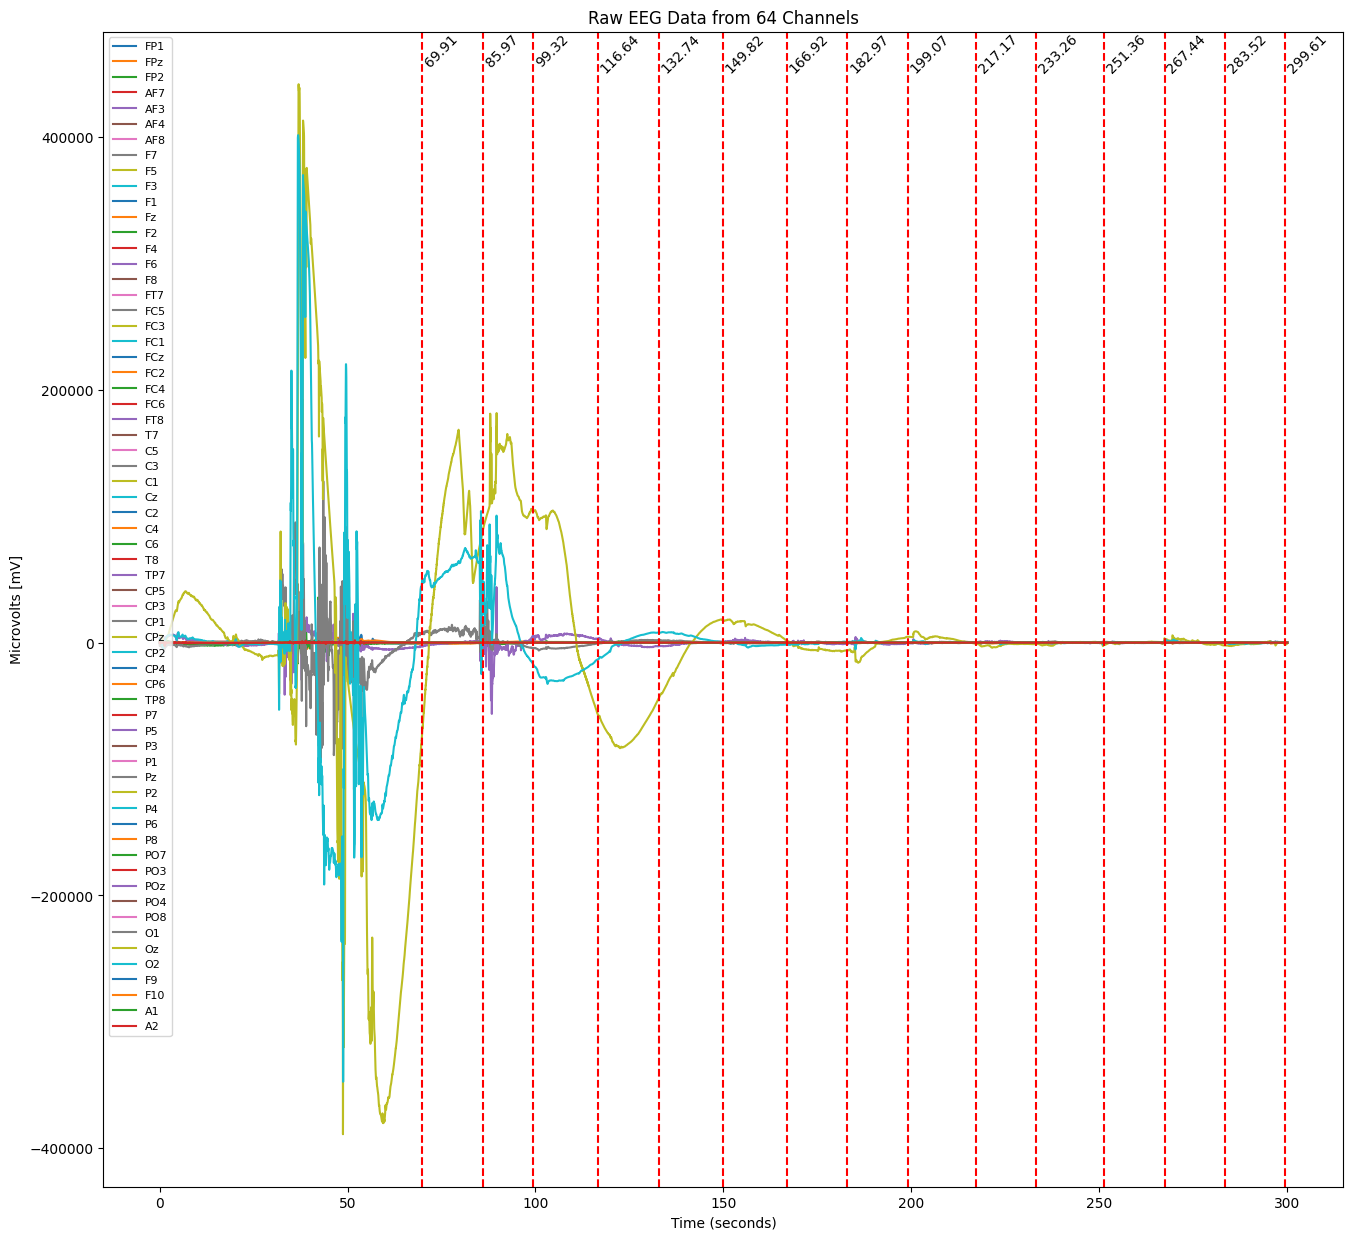

In [9]:
# Set the start and end time for the plot
raw_data_plot = raw_data_df[(raw_data_df['Time']>=0) & (raw_data_df['Time']<=360)]
# Get specific channel from the data
# raw_data_plot_idx = raw_data_plot[['Time', 'Channel_1']]
# Plot raw EEG data using plotly express
# plot_Plotly_Express(raw_data_plot, f'Raw EEG Data from {channels} Channels', {'Time': 'Time (seconds)', 'value': 'Microvolts [mV]'}, data_asynchron_times)
# Plot raw EEG data using pyplot
plot_PyPlot(raw_data_plot, f'Raw EEG Data from {channels} Channels', 'Time (seconds)', 'Microvolts [mV]', data_asynchron_times)

In [10]:
raw_data_plot

FP1         FPz         FP2         AF7         AF3  \
0       457.125000  495.312500  242.062500  339.078125  226.015625   
1       449.578125  488.328125  236.171875  331.281250  218.640625   
2       448.937500  488.187500  237.156250  330.437500  218.250000   
3       441.062500  480.562500  230.671875  322.234375  210.531250   
4       436.218750  475.703125  226.906250  316.875000  205.640625   
...            ...         ...         ...         ...         ...   
153613   -7.500977  -11.393555   -4.654297    1.670410   -3.631836   
153614   -5.607422   -9.673828   -4.988281    2.471191   -2.185547   
153615  -10.310547  -14.465820  -11.655273   -3.145996   -7.142578   
153616   -6.423828  -10.875000   -9.430664    0.091309   -3.541016   
153617   -4.367188   -9.351562   -8.708984    1.854980   -1.854492   

                AF4         AF8          F7         F5         F3  ...  \
0      -1285.343750 -225.224609  501.718750 -39.332031   8.296875  ...   
1      -1292.531250 -231.271484  493.593750 -47.656250   0.910156  ...   
2      -1292.609375 -230.578125  492.734375 -48.843750   0.488281  ...   
3      -1299.765625 -237.244141  484.468750 -57.085938  -7.128906  ...   
4      -1303.968750 -241.091797  478.703125 -62.160156 -11.750000  ...   
...             ...         ...         ...        ...        ...  ...   
153613    -2.166260    0.485840    1.801758  10.215454   2.893066  ...   
153614    -1.568115    0.199707    3.312500  10.930481   3.950684  ...   
153615    -7.163330   -6.288574   -1.790039   5.191223  -1.397949  ...   
153616    -4.085205   -3.791016    1.503906   8.196777   1.912109  ...   
153617    -2.887451   -2.635742    2.795898   9.548279   3.405273  ...   

               PO4         PO8           O1           Oz           O2  \
0       483.156250  191.476562 -2453.687500  5856.000000  3029.125000   
1       474.843750  183.796875 -2449.562500  5875.000000  3022.750000   
2       473.687500  182.953125 -2444.937500  5893.500000  3016.625000   
3       466.390625  174.929688 -2440.000000  5913.000000  3010.375000   
4       461.281250  170.062500 -2434.750000  5934.000000  3003.750000   
...            ...         ...          ...          ...          ...   
153613   25.007812   10.722656    62.140625  -756.000000   364.343750   
153614   25.003906   10.225098    61.103516  -746.679688   361.578125   
153615   18.843750    3.139893    59.277344  -737.632812   358.593750   
153616   20.570312    4.310059    57.154297  -728.617188   355.843750   
153617   21.386719    3.791016    54.826172  -719.429688   353.546875   

               F9         F10          A1         A2        Time  
0       72.664062 -114.962891  455.437500  80.351562    0.000000  
1       64.460938 -121.396484  447.484375  73.562500    0.001953  
2       63.312500 -120.853516  446.687500  73.523438    0.003906  
3       55.140625 -127.611328  438.734375  66.007812    0.005859  
4       50.382812 -131.467773  433.984375  61.468750    0.007812  
...           ...         ...         ...        ...         ...  
153613  -6.499023    5.860352   -8.365234  -2.392578  300.025391  
153614  -4.530273    6.795410   -6.897949  -1.245117  300.027344  
153615  -9.066895    1.540527  -11.981934  -6.942383  300.029297  
153616  -5.084473    5.071777   -8.452637  -4.182617  300.031250  
153617  -2.963379    6.937988   -6.791504  -3.051758  300.033203  

[153618 rows x 65 columns]

In [11]:
raw_data

<RawArray | 64 x 153618 (300.0 s), ~75.1 MB, data loaded>

## Manually Remove the Channels

In [12]:
# Remove channels from the data 
def remove_channels(data_samples, raw_data_df, channels, channel_names, channels_to_remove):
    # Get the index of the channels to remove
    channels_to_remove_index = [channel_names.index(channel) for channel in channels_to_remove]
    # Remove the channels from the data_samples
    data_samples = np.delete(data_samples, channels_to_remove_index, axis=1)
    # Remove the channels from the raw_data
    raw_data_df = raw_data_df.drop(columns=channels_to_remove)
    # Remove the channels from the channel_names
    channel_names = [channel for channel in channel_names if channel not in channels_to_remove]
    # Change the number of channels
    channels = channels - len(channels_to_remove)
    return data_samples, raw_data_df, channels, channel_names

# Channels to remove
channels_to_remove = ['Oz', 'O2', 'O1']
# Remove the channels
data_samples, raw_data_df, channels, channel_names = \
    remove_channels(data_samples, raw_data_df, channels, channel_names, channels_to_remove)

# Pass the updated dataframes to MNE
info = mne.create_info(ch_names=channel_names, sfreq=sampling_rate, ch_types='eeg')
raw_data = mne.io.RawArray(data_samples.T, info)

Creating RawArray with float64 data, n_channels=61, n_times=153618
    Range : 0 ... 153617 =      0.000 ...   300.033 secs
Ready.


## Plot Updated Raw EEG Data

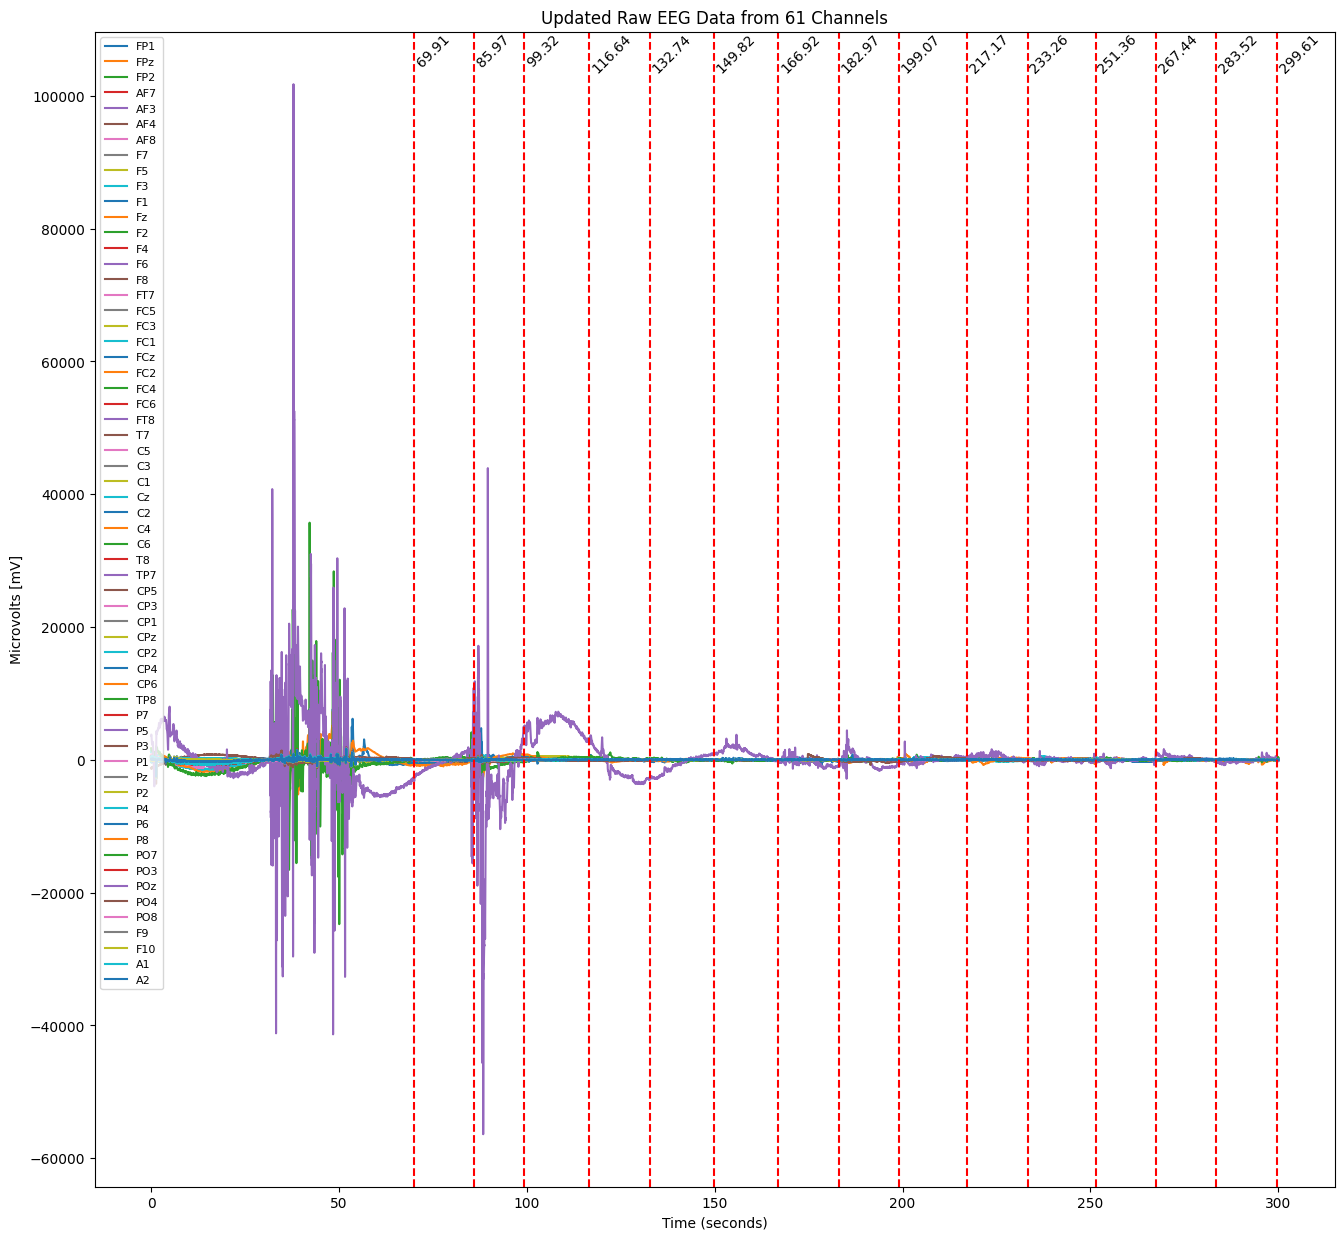

In [13]:
# Set the start and end time for the plot
raw_data_plot = raw_data_df[(raw_data_df['Time']>=0) & (raw_data_df['Time']<=360)]
# Plot raw EEG data using plotly express
# plot_Plotly_Express(raw_data_plot, f'Raw EEG Data from {channels} Channels', {'Time': 'Time (seconds)', 'value': 'Microvolts [mV]'}, data_asynchron_times)
# Plot raw EEG data using pyplot
plot_PyPlot(raw_data_plot, f'Updated Raw EEG Data from {channels} Channels', 'Time (seconds)', 'Microvolts [mV]', data_asynchron_times)

In [14]:
# Channels to remove
channels_to_remove = ['POz', 'PO7', 'P6', 'P8']
# Remove the channels
data_samples, raw_data_df, channels, channel_names = \
    remove_channels(data_samples, raw_data_df, channels, channel_names, channels_to_remove)

# Pass the updated dataframes to MNE
info = mne.create_info(ch_names=channel_names, sfreq=sampling_rate, ch_types='eeg')
raw_data = mne.io.RawArray(data_samples.T, info)

Creating RawArray with float64 data, n_channels=57, n_times=153618
    Range : 0 ... 153617 =      0.000 ...   300.033 secs
Ready.


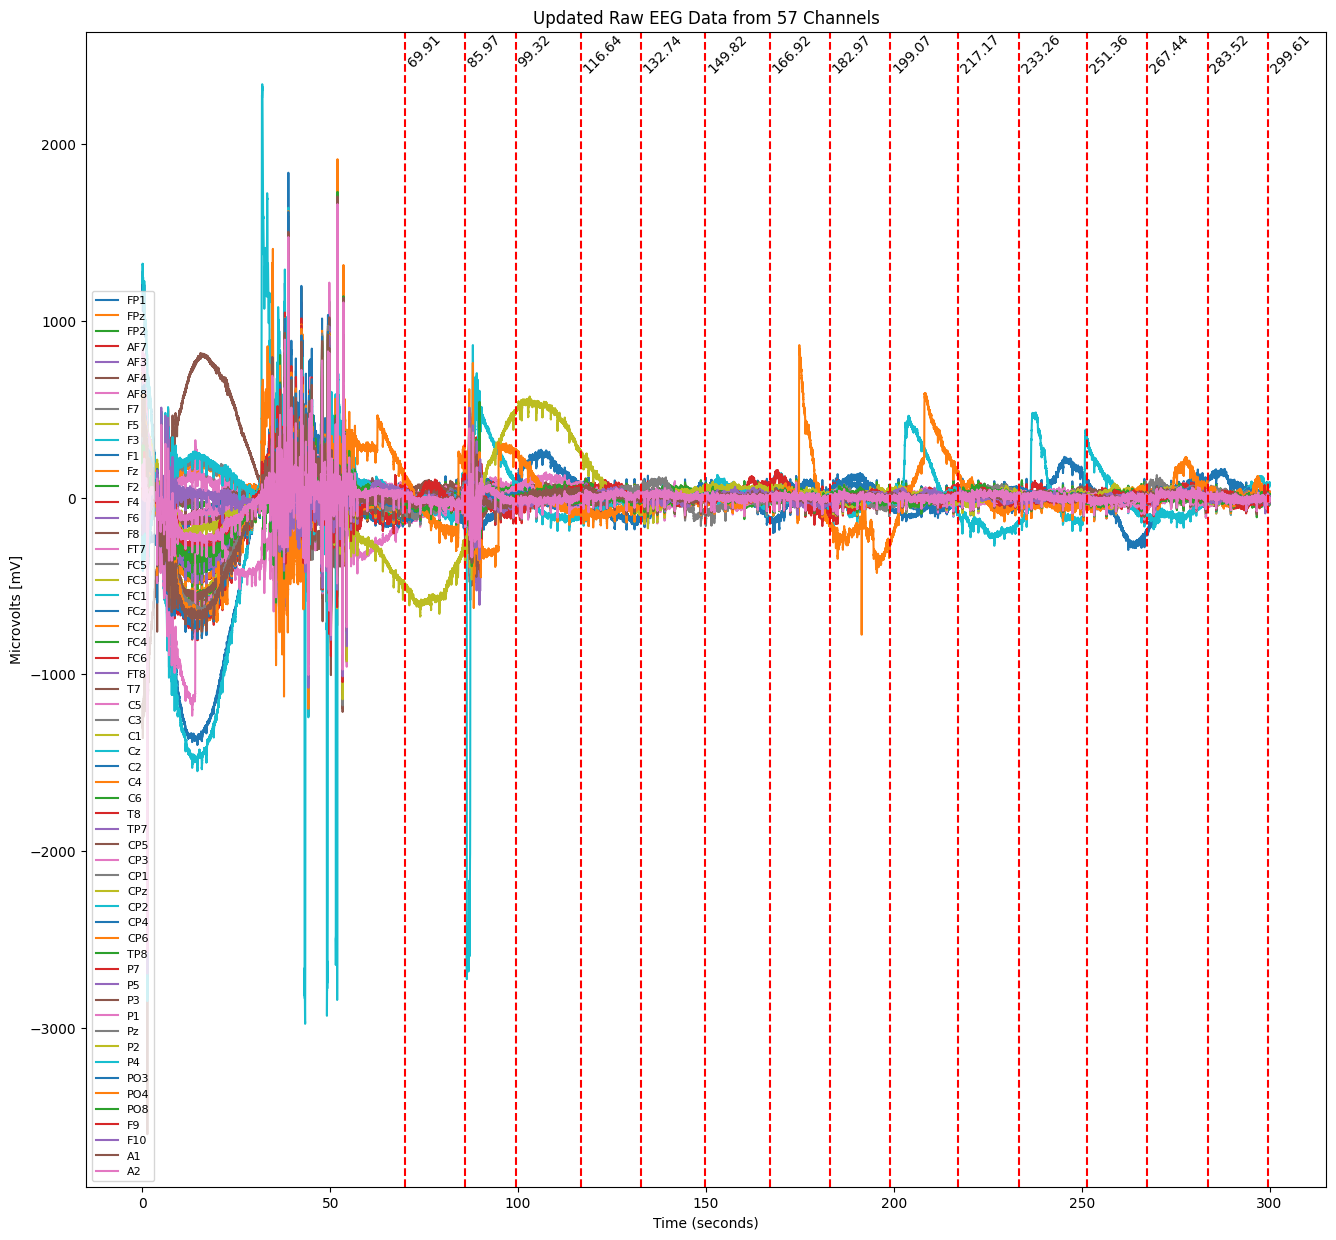

In [15]:
# Set the start and end time for the plot
raw_data_plot = raw_data_df[(raw_data_df['Time']>=0) & (raw_data_df['Time']<=360)]
# Plot raw EEG data using plotly express
# plot_Plotly_Express(raw_data_plot, f'Raw EEG Data from {channels} Channels', {'Time': 'Time (seconds)', 'value': 'Microvolts [mV]'}, data_asynchron_times)
# Plot raw EEG data using pyplot
plot_PyPlot(raw_data_plot, f'Updated Raw EEG Data from {channels} Channels', 'Time (seconds)', 'Microvolts [mV]', data_asynchron_times)

## Apply Re-referencing

EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.


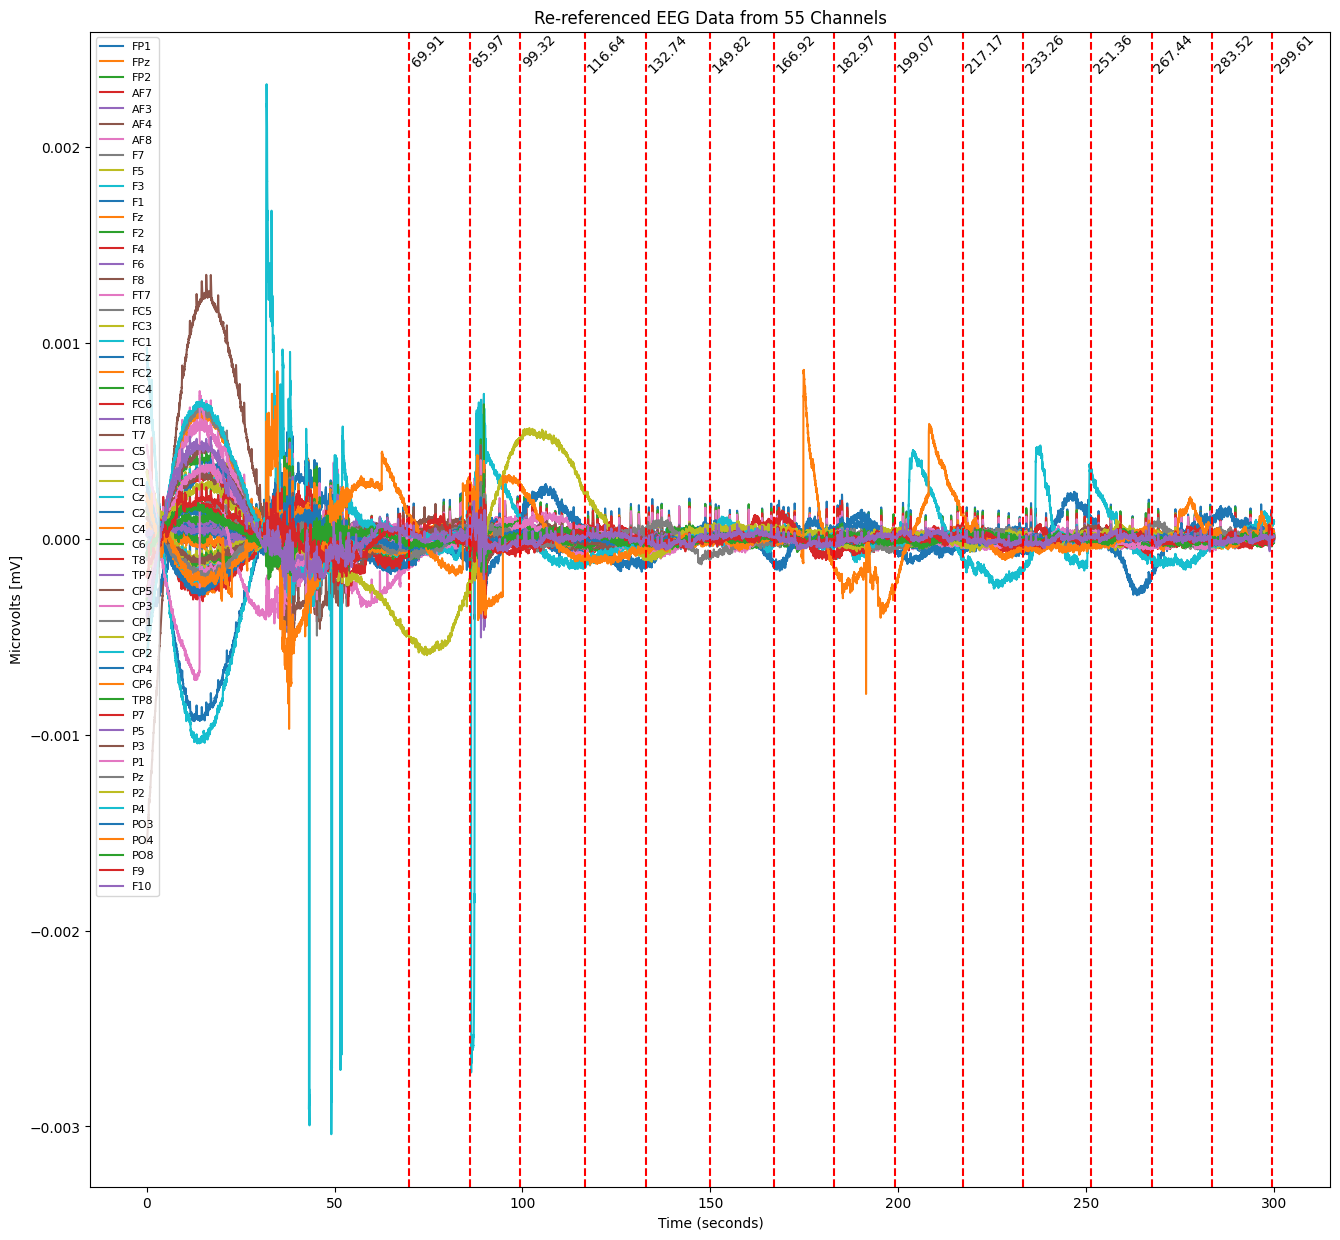

In [16]:
# Apply re-referencing to the data, using channel 63 and 64 as reference
reference_channels = ['A1', 'A2']
raw_data.set_eeg_reference(ref_channels=reference_channels)
raw_data_df_ref = pd.DataFrame(raw_data.get_data().T, columns=channel_names)
raw_data_df_ref['Time'] = time

# Drop the reference channels from the dataframe
raw_data_df_ref = raw_data_df_ref.drop(columns=reference_channels)
channels = channels - len(reference_channels)

# Set the start and end time for the plot
raw_data_df_ref_plot = raw_data_df_ref[(raw_data_df_ref['Time']>=0) & (raw_data_df_ref['Time']<=360)]

# Plot re-referenced EEG data using plotly express
# plot_Plotly_Express(raw_data_df_ref_plot, f'Re-referenced EEG Data from {channels} Channels', {'Time': 'Time (seconds)', 'value': 'Microvolts [mV]'}, data_asynchron_times)
# Plot re-referenced EEG data using pyplot
plot_PyPlot(raw_data_df_ref_plot, f'Re-referenced EEG Data from {channels} Channels', 'Time (seconds)', 'Microvolts [mV]', data_asynchron_times)

## Apply Band-pass Filter

In [17]:
# Apply a bandpass filter to the data using MNE
band_filtered_eeg = raw_data.filter(l_freq=0.1, h_freq=30, fir_design="firwin")
band_data = band_filtered_eeg.get_data()

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16897 samples (33.002 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  57 out of  57 | elapsed:    0.3s finished


## Plot Band-pass Filtered Data

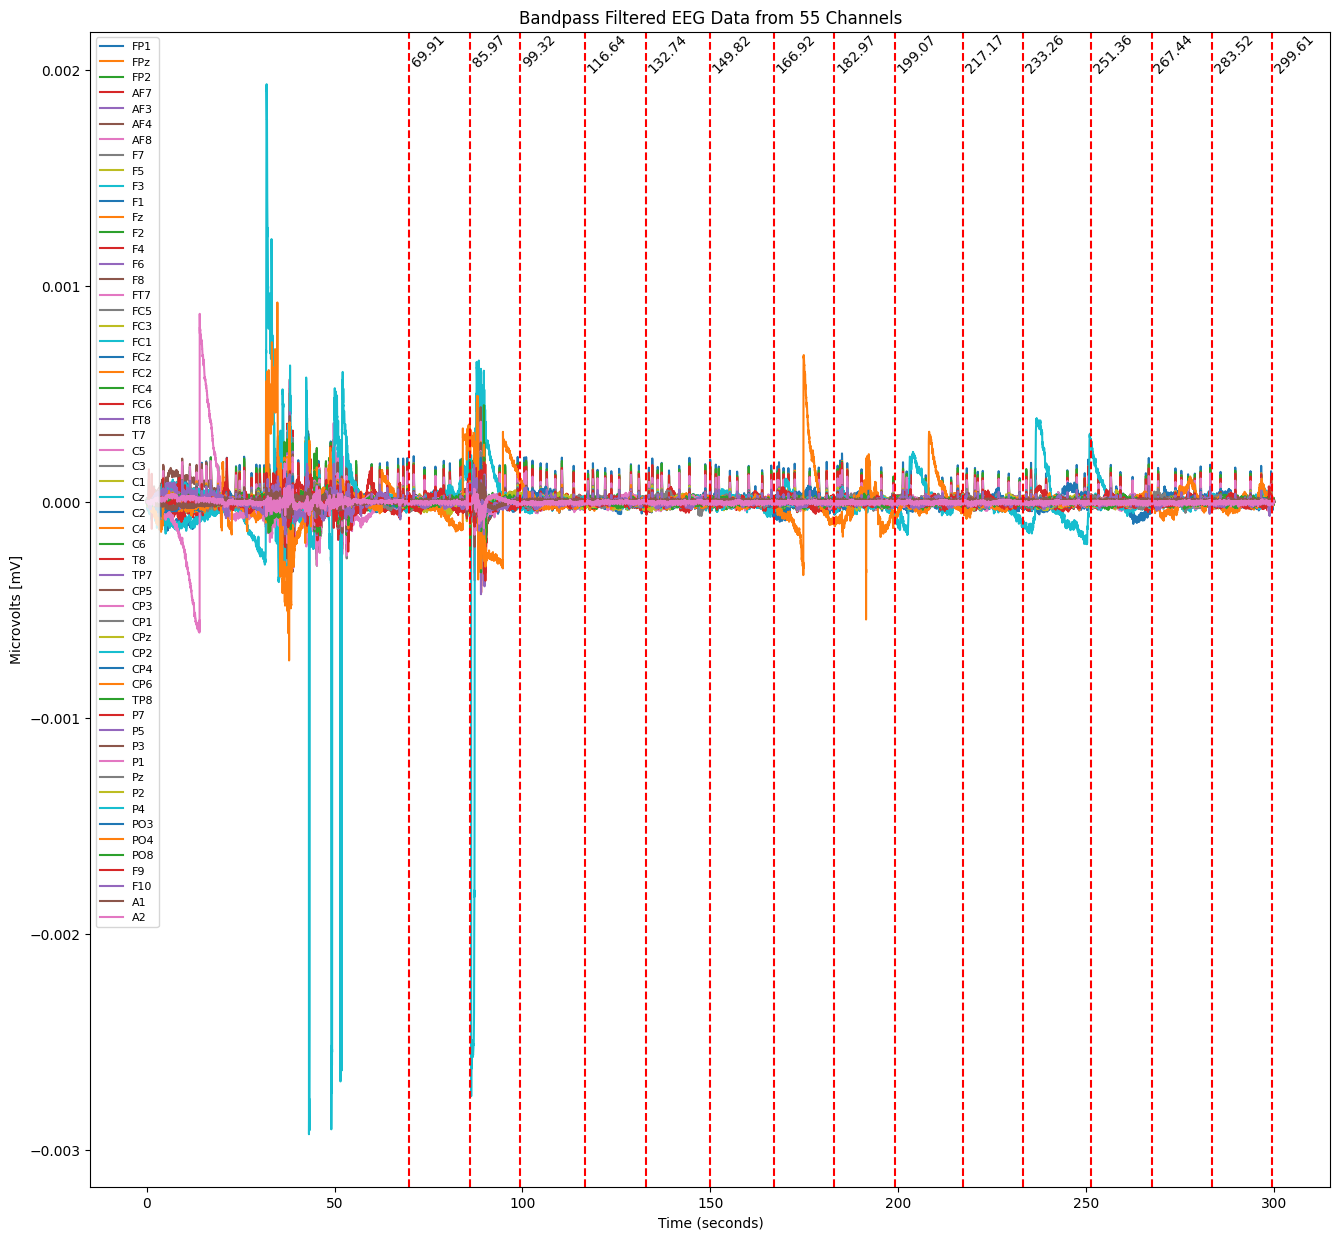

In [18]:
# Create a pandas DataFrame from the bandpass filtered data
band_data_df = pd.DataFrame(band_data.T, columns=channel_names)
band_data_df['Time'] = band_filtered_eeg.times
# Set the start and end time for the plot
band_data_df_plot = band_data_df[(band_data_df['Time']>=0) & (band_data_df['Time']<=360)]
# Plot the filtered EEG data using plotly express
# plot_Plotly_Express(band_data_df_plot, f'Bandpass Filtered EEG Data from {channels} Channels', {'Time': 'Time (seconds)', 'value': 'Microvolts [mV]'}, data_asynchron_times)
# Plot the bandpass filtered EEG data using pyplot
plot_PyPlot(band_data_df_plot, f'Bandpass Filtered EEG Data from {channels} Channels', 'Time (seconds)', 'Microvolts [mV]', data_asynchron_times)

## Apply Notch Filter

In [19]:
# Apply notch filter to the data using MNE
notch_filtered_eeg = band_filtered_eeg.notch_filter(freqs=60)
notch_data = notch_filtered_eeg.get_data()

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 3381 samples (6.604 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  57 out of  57 | elapsed:    0.3s finished


## Plot Notch Filtered Data

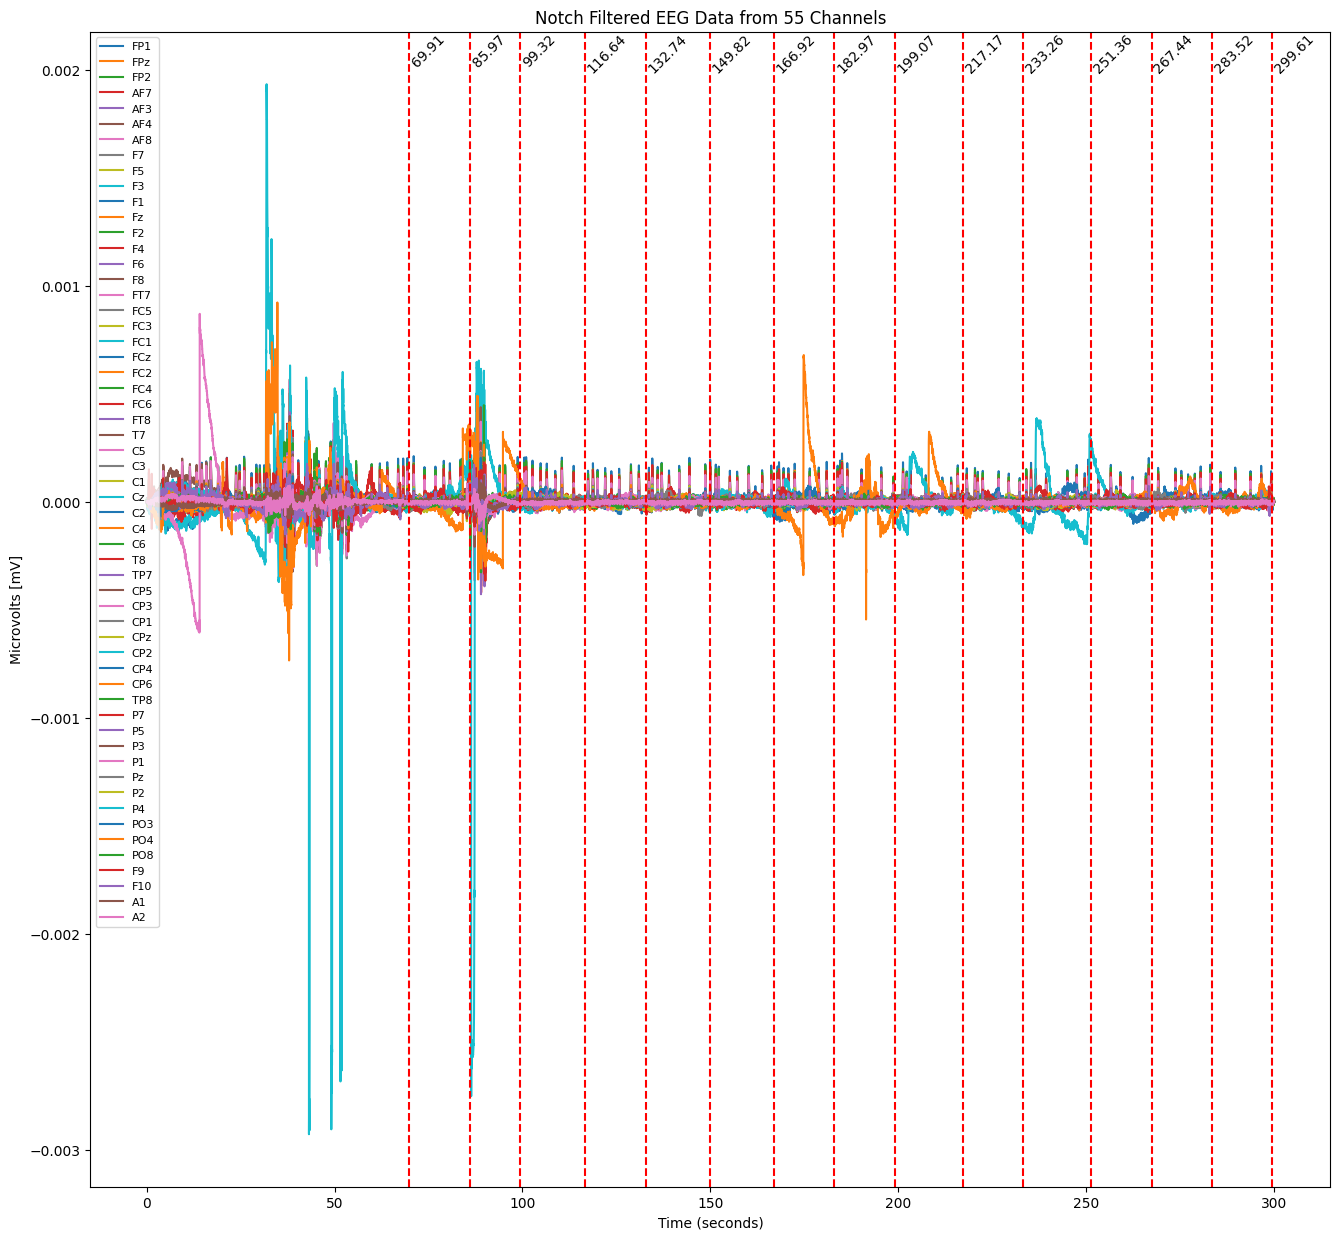

In [20]:
# Format the notch filtered data into a pandas DataFrame
notch_data_df = pd.DataFrame(notch_data.T, columns=channel_names)
notch_data_df['Time'] = notch_filtered_eeg.times

# Plot the notch filtered EEG data using plotly express
# plot_Plotly_Express(notch_data_df, 0, 120, f'Notch Filtered EEG Data from {channels} Channels', {'Time': 'Time (seconds)', 'value': 'Microvolts [mV]'})

# Plot the notch filtered EEG data using pyplot
plot_PyPlot(notch_data_df, f'Notch Filtered EEG Data from {channels} Channels', 'Time (seconds)', 'Microvolts [mV]', data_asynchron_times)

## Independent Component Analysis (ICA)

Fitting ICA to data using 57 channels (please be patient, this may take a while)


Selecting by number: 55 components
Fitting ICA took 14.6s.
Creating RawArray with float64 data, n_channels=55, n_times=153618
    Range : 0 ... 153617 =      0.000 ...   300.033 secs
Ready.
Using matplotlib as 2D backend.


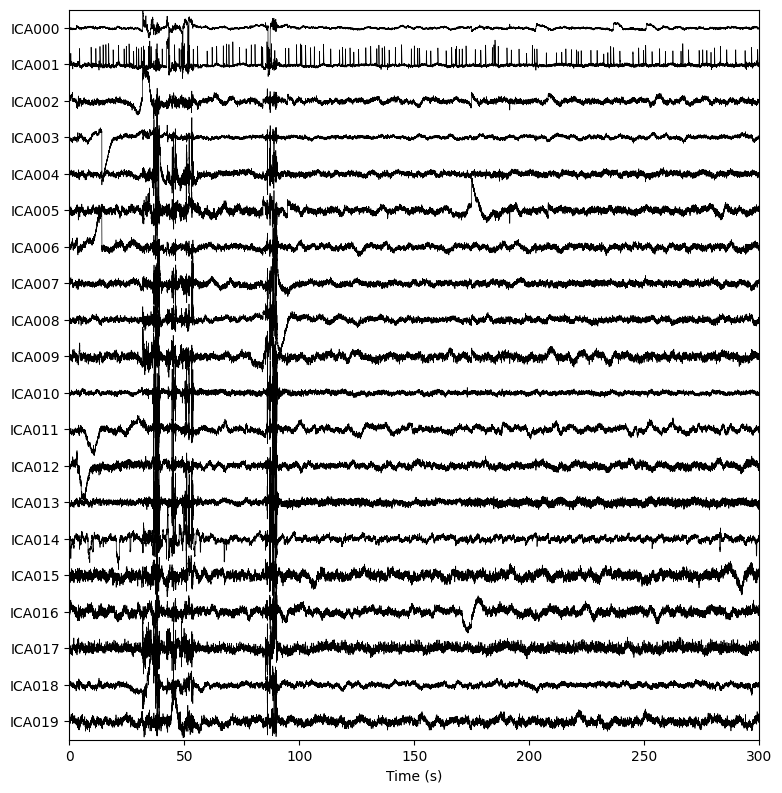

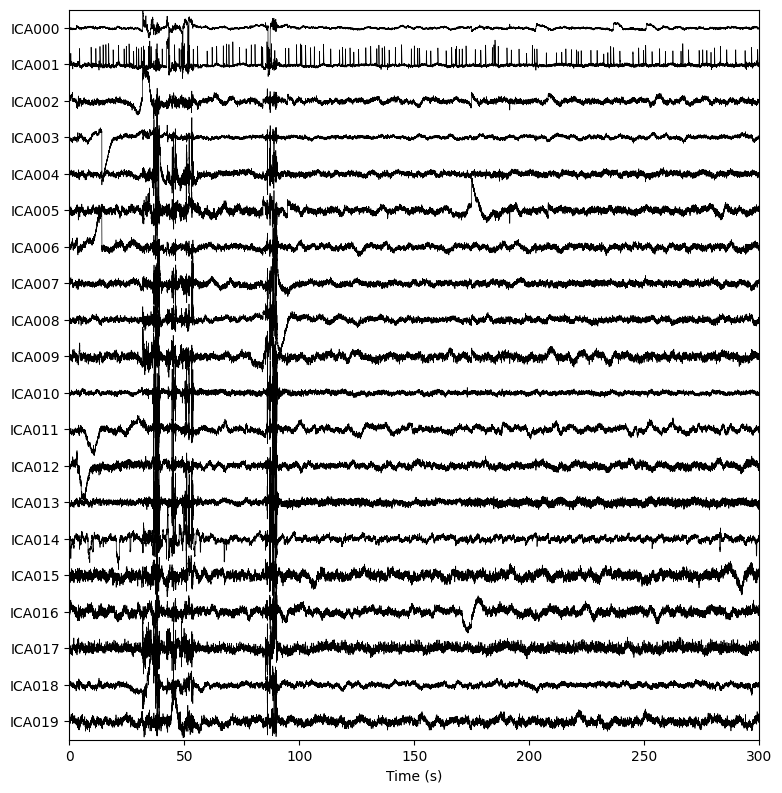

In [21]:
# Apply ICA to the data using MNE https://mne.tools/stable/generated/mne.preprocessing.ICA.html 
ica = mne.preprocessing.ICA(n_components=channels, random_state=97, max_iter="auto")
ica.fit(notch_filtered_eeg)
ica.plot_sources(notch_filtered_eeg, show_scrollbars=False, start=0, stop=num_samples)

In [22]:
ica

<ICA | raw data decomposition, method: fastica (fit in 82 iterations on 153618 samples), 55 ICA components (57 PCA components available), channel types: eeg, no sources marked for exclusion>

## Remove the EOG artifacts

In [23]:
# # Remove the EOG artifacts from the data using MNE
# eog_indices, eog_scores = ica.find_bads_eog(notch_filtered_eeg)
# ica.plot_scores(eog_scores)
# # No EOG channel(s) found

## Remove Artifact

Applying ICA to Raw instance
    Transforming to ICA space (55 components)
    Zeroing out 2 ICA components
    Projecting back using 57 PCA components


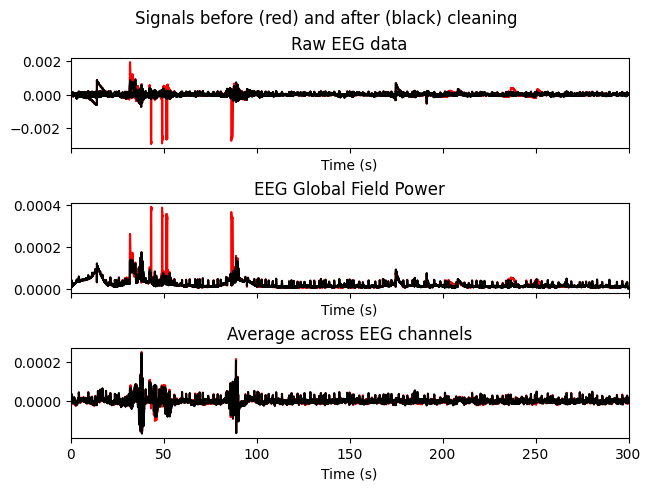

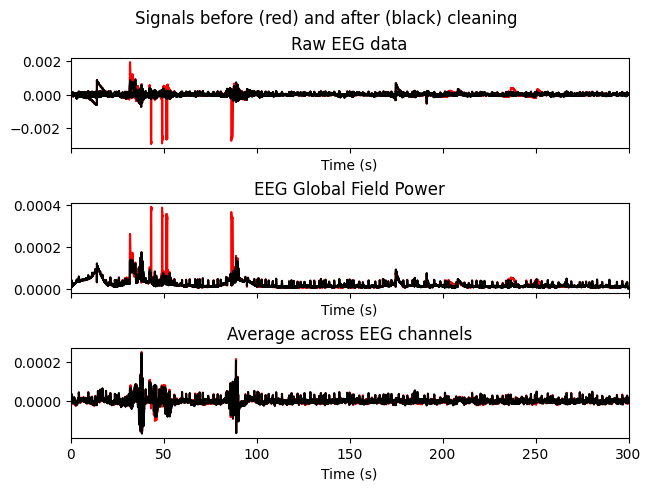

In [24]:
# blinks
exclude = [0, 19]
ica.plot_overlay(notch_filtered_eeg, exclude=exclude, picks="eeg", start=0, stop=num_samples)

In [25]:
# Get Data that removed the specified components from the data using MNE
ica.exclude = exclude
cleaned_eeg = ica.apply(notch_filtered_eeg)
cleaned_eeg

Applying ICA to Raw instance
    Transforming to ICA space (55 components)
    Zeroing out 2 ICA components
    Projecting back using 57 PCA components


<RawArray | 57 x 153618 (300.0 s), ~66.9 MB, data loaded>

## Plot the cleaned EEG data

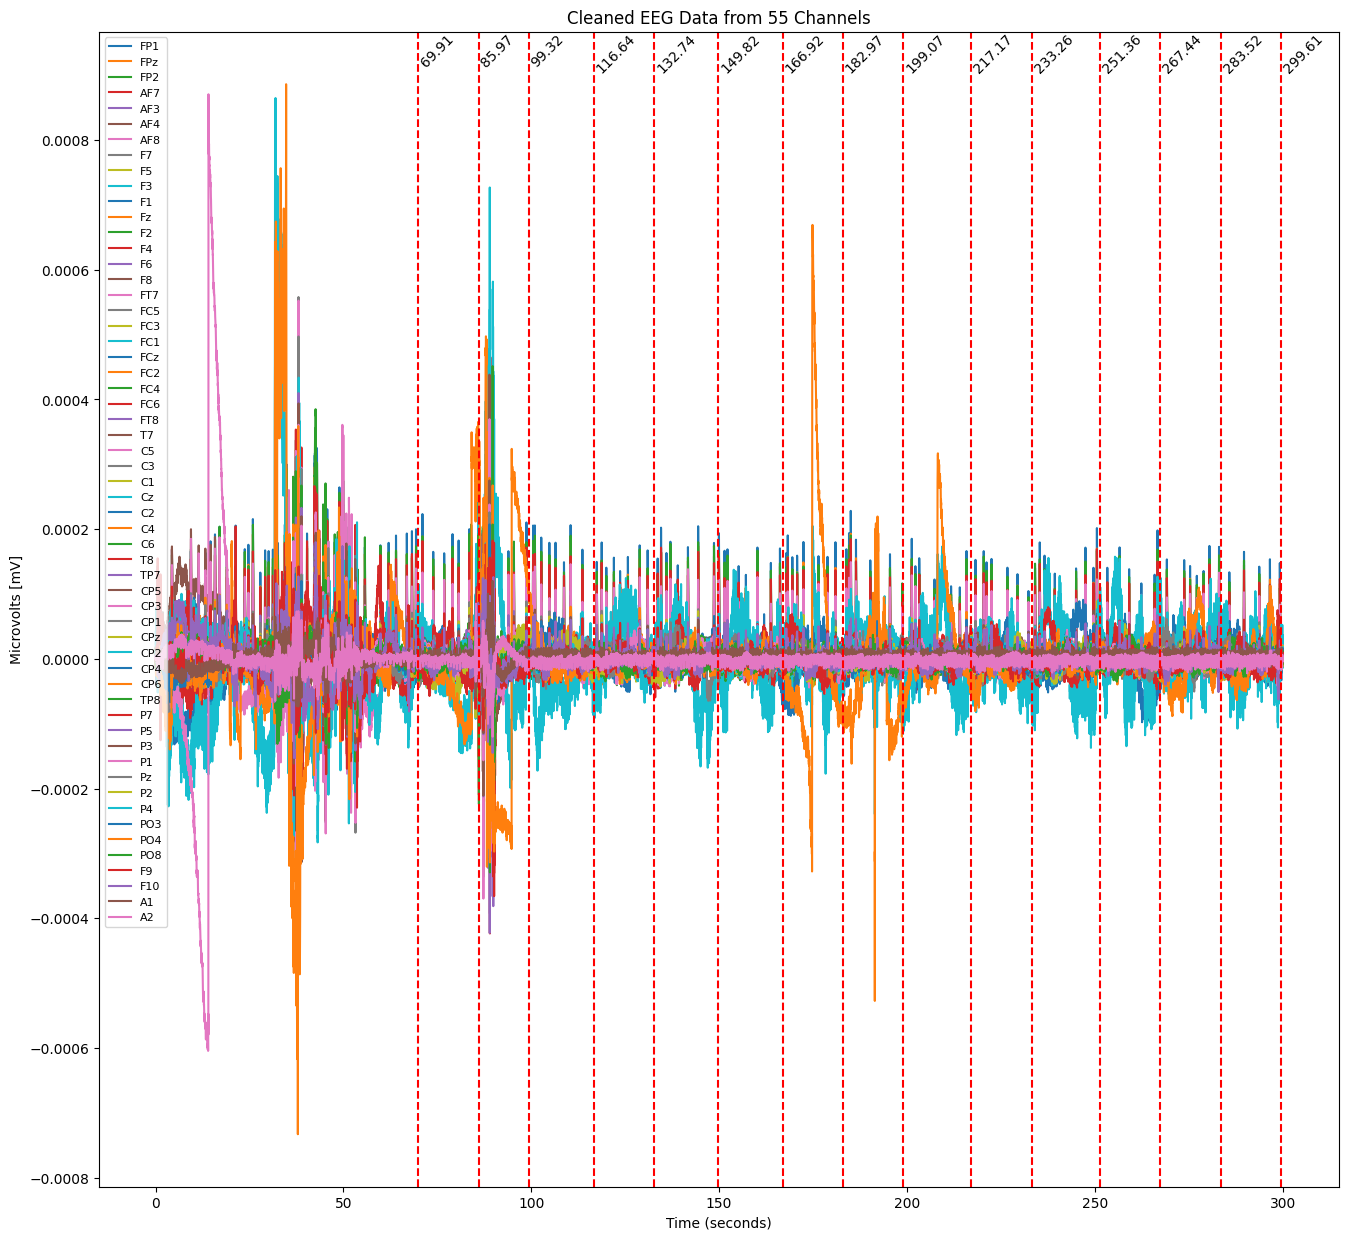

In [26]:
# Format the cleaned data into a pandas DataFrame
cleaned_data = cleaned_eeg.get_data()
cleaned_data_df = pd.DataFrame(cleaned_data.T, columns=channel_names)
cleaned_data_df['Time'] = cleaned_eeg.times 

# Plot the cleaned EEG data using plotly express
# plot_Plotly_Express(cleaned_data_df, f'Cleaned EEG Data from {channels} Channels', {'Time': 'Time (seconds)', 'value': 'Microvolts [mV]'})

# Plot the cleaned EEG data using pyplot
plot_PyPlot(cleaned_data_df, f'Cleaned EEG Data from {channels} Channels', 'Time (seconds)', 'Microvolts [mV]', data_asynchron_times)

In [27]:
cleaned_data.shape

(57, 153618)

## Power Spectual Density

In [28]:
# Calculate the Power Spectral Density (PSD) of the cleaned EEG data 
# using MNE's mne.io.RawArray.compute_psd() method
# Two methods are used: Welch and Multitaper
welch_psd = cleaned_eeg.compute_psd(method='welch', fmin=0, fmax=30, n_fft=int(20*sampling_rate))
multitaper_psd = cleaned_eeg.compute_psd(method='multitaper', fmin=0, fmax=30)
welch_psd_df = welch_psd.to_data_frame(copy=True)
welch_psd

Effective window size : 20.000 (s)


    Using multitaper spectrum estimation with 1 DPSS windows


C:\Users\aiden\AppData\Local\Temp\ipykernel_14368\776075539.py:5: RuntimeWarning: Could not properly use low_bias, keeping lowest-bias taper
  multitaper_psd = cleaned_eeg.compute_psd(method='multitaper', fmin=0, fmax=30)


<Power Spectrum (from Raw, welch method) | 57 channels × 601 freqs, 0.0-30.0 Hz>

## Define Plotting Functions

In [29]:
# Plot the frequence band data from welch PSD using plotly express
def plot_Plotly_Express_PSD(data_df, title, labels):
    fig = px.line(
        data_df, 
        x='freq', 
        y=data_df.columns[1:], 
        title=title,
        labels=labels)
    fig.show()

# Plot the frequence band data from welch PSD using pyplot
def plot_PyPlot_PSD(data_df, title, x_label, y_label):
    plt.figure(figsize=(16, 16))
    plt.plot(data_df['freq'], data_df.iloc[:,1:])
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend(data_df.columns[1:], loc="best", prop={'size': 8})
    plt.show()

# Initialize data with each frequency band
delta_band = welch_psd_df[(welch_psd_df['freq']>=0.5) & (welch_psd_df['freq']<4)]
theta_band = welch_psd_df[(welch_psd_df['freq']>=4) & (welch_psd_df['freq']<8)]
alpha_band = welch_psd_df[(welch_psd_df['freq']>=8) & (welch_psd_df['freq']<12)]
beta_band = welch_psd_df[(welch_psd_df['freq']>=12) & (welch_psd_df['freq']<30)]
low_beta_band = welch_psd_df[(welch_psd_df['freq']>=12) & (welch_psd_df['freq']<20)]
high_beta_band = welch_psd_df[(welch_psd_df['freq']>=20) & (welch_psd_df['freq']<30)]
gamma_band = welch_psd_df[(welch_psd_df['freq']>=30) & (welch_psd_df['freq']<=120)]

# Save the data to a pandas matrix, with each column representing a average frequency band, and each row representing a channel
welch_psd_matrix = np.array([delta_band.mean().values[1:], theta_band.mean().values[1:], alpha_band.mean().values[1:], beta_band.mean().values[1:], low_beta_band.mean().values[1:], high_beta_band.mean().values[1:]])
welch_psd_matrix_df = pd.DataFrame(welch_psd_matrix.T, index=welch_psd_df.columns[1:], columns=['Delta', 'Theta', 'Alpha', 'Beta', 'Low Beta', 'High Beta'])

welch_psd_matrix_df

Delta         Theta         Alpha          Beta      Low Beta  \
FP1  3.108675e-10  4.374114e-11  6.933003e-12  1.101091e-12  1.464918e-12   
FPz  2.432410e-10  3.385805e-11  5.672836e-12  9.810230e-13  1.262525e-12   
FP2  2.885042e-10  3.723537e-11  6.171937e-12  1.445576e-12  1.727783e-12   
AF7  2.099284e-10  2.942377e-11  5.583002e-12  1.377759e-12  1.775821e-12   
AF3  8.988305e-11  1.471826e-11  4.089754e-12  1.165897e-12  1.465338e-12   
AF4  8.789359e-11  1.395360e-11  4.494498e-12  1.522113e-12  1.835249e-12   
AF8  1.871544e-10  2.386749e-11  5.868775e-12  2.465073e-12  2.643221e-12   
F7   5.615442e-11  8.036093e-12  2.774254e-12  1.030341e-12  1.326453e-12   
F5   5.804199e-11  1.207359e-11  5.021622e-12  2.061599e-12  2.444249e-12   
F3   4.679098e-11  1.008087e-11  4.332059e-12  1.470617e-12  1.791743e-12   
F1   4.684977e-11  9.427294e-12  4.038808e-12  1.285794e-12  1.617955e-12   
Fz   3.982024e-11  8.758070e-12  3.912446e-12  1.238226e-12  1.548739e-12   
F2   4.150597e-11  8.596092e-12  3.882321e-12  1.348622e-12  1.699669e-12   
F4   4.912486e-11  9.541844e-12  4.659962e-12  1.884955e-12  2.307142e-12   
F6   6.782185e-11  1.226361e-11  6.677737e-12  3.507952e-12  4.026229e-12   
F8   4.753488e-11  6.730752e-12  2.492057e-12  1.155259e-12  1.510256e-12   
FT7  2.708585e-11  4.715352e-12  2.407123e-12  1.320079e-12  1.401420e-12   
FC5  5.117050e-11  1.346577e-11  8.090489e-12  3.525927e-12  3.994453e-12   
FC3  3.908527e-11  1.098827e-11  6.504209e-12  2.443716e-12  2.864904e-12   
FC1  3.103592e-11  7.843970e-12  4.358002e-12  1.415431e-12  1.761122e-12   
FCz  3.405127e-11  9.020983e-12  4.986432e-12  1.587724e-12  2.129105e-12   
FC2  3.042497e-11  6.929640e-12  4.037107e-12  1.445970e-12  1.869641e-12   
FC4  3.746060e-11  8.388326e-12  5.520455e-12  2.589087e-12  3.328539e-12   
FC6  6.565658e-11  1.477293e-11  1.117441e-11  6.908947e-12  8.517765e-12   
FT8  5.527980e-11  5.700295e-12  2.945100e-12  2.164275e-12  2.872452e-12   
T7   4.405825e-11  5.378480e-12  2.773113e-12  1.824063e-12  1.881419e-12   
C5   5.700360e-11  1.462920e-11  1.190827e-11  5.009240e-12  5.620371e-12   
C3   3.447762e-11  1.062634e-11  7.825157e-12  2.876953e-12  3.363711e-12   
C1   2.645254e-11  6.726591e-12  4.620192e-12  1.522034e-12  1.876027e-12   
Cz   2.998217e-10  3.525981e-11  2.170710e-11  1.156483e-11  1.446198e-11   
C2   2.602034e-11  5.788995e-12  3.775275e-12  1.363132e-12  1.827109e-12   
C4   2.906711e-11  6.749167e-12  5.000541e-12  2.361363e-12  3.150796e-12   
C6   4.207760e-11  1.136017e-11  9.368227e-12  6.220714e-12  8.223109e-12   
T8   9.869698e-11  6.808527e-12  2.930493e-12  1.647129e-12  2.141687e-12   
TP7  2.975001e-11  8.974229e-12  7.781865e-12  2.800823e-12  3.344339e-12   
CP5  3.164981e-11  9.196848e-12  7.940690e-12  2.863341e-12  3.417255e-12   
CP3  2.570087e-11  7.482060e-12  5.939413e-12  2.038303e-12  2.486031e-12   
CP1  2.191151e-11  5.456976e-12  4.055295e-12  1.277439e-12  1.620129e-12   
CPz  2.191443e-11  4.638216e-12  3.634668e-12  1.100819e-12  1.444057e-12   
CP2  2.187410e-11  4.610901e-12  3.425729e-12  1.167236e-12  1.582670e-12   
CP4  2.275107e-11  5.122808e-12  3.967425e-12  1.670134e-12  2.303239e-12   
CP6  2.498026e-11  6.148226e-12  5.161804e-12  2.972455e-12  4.111570e-12   
TP8  2.204110e-11  4.313184e-12  4.134381e-12  2.645843e-12  3.415638e-12   
P7   1.789324e-11  4.543085e-12  3.698622e-12  1.269525e-12  1.627590e-12   
P5   1.774479e-11  4.605471e-12  3.817716e-12  1.295600e-12  1.660838e-12   
P3   1.793674e-11  4.593346e-12  3.740010e-12  1.275275e-12  1.633757e-12   
P1   2.338524e-10  1.719644e-11  6.897530e-12  1.788364e-12  2.675172e-12   
Pz   2.507019e-11  4.644553e-12  3.367335e-12  1.023507e-12  1.412252e-12   
P2   1.996977e-11  4.109673e-12  3.465606e-12  1.096415e-12  1.512427e-12   
P4   1.947914e-11  4.226594e-12  3.534332e-12  1.260672e-12  1.744532e-12   
PO3  1.626329e-11  3.840620e-12  3.112397e-12  1.005522e-12  1.372366e-12   
PO4  4.2

## All Frequency Band

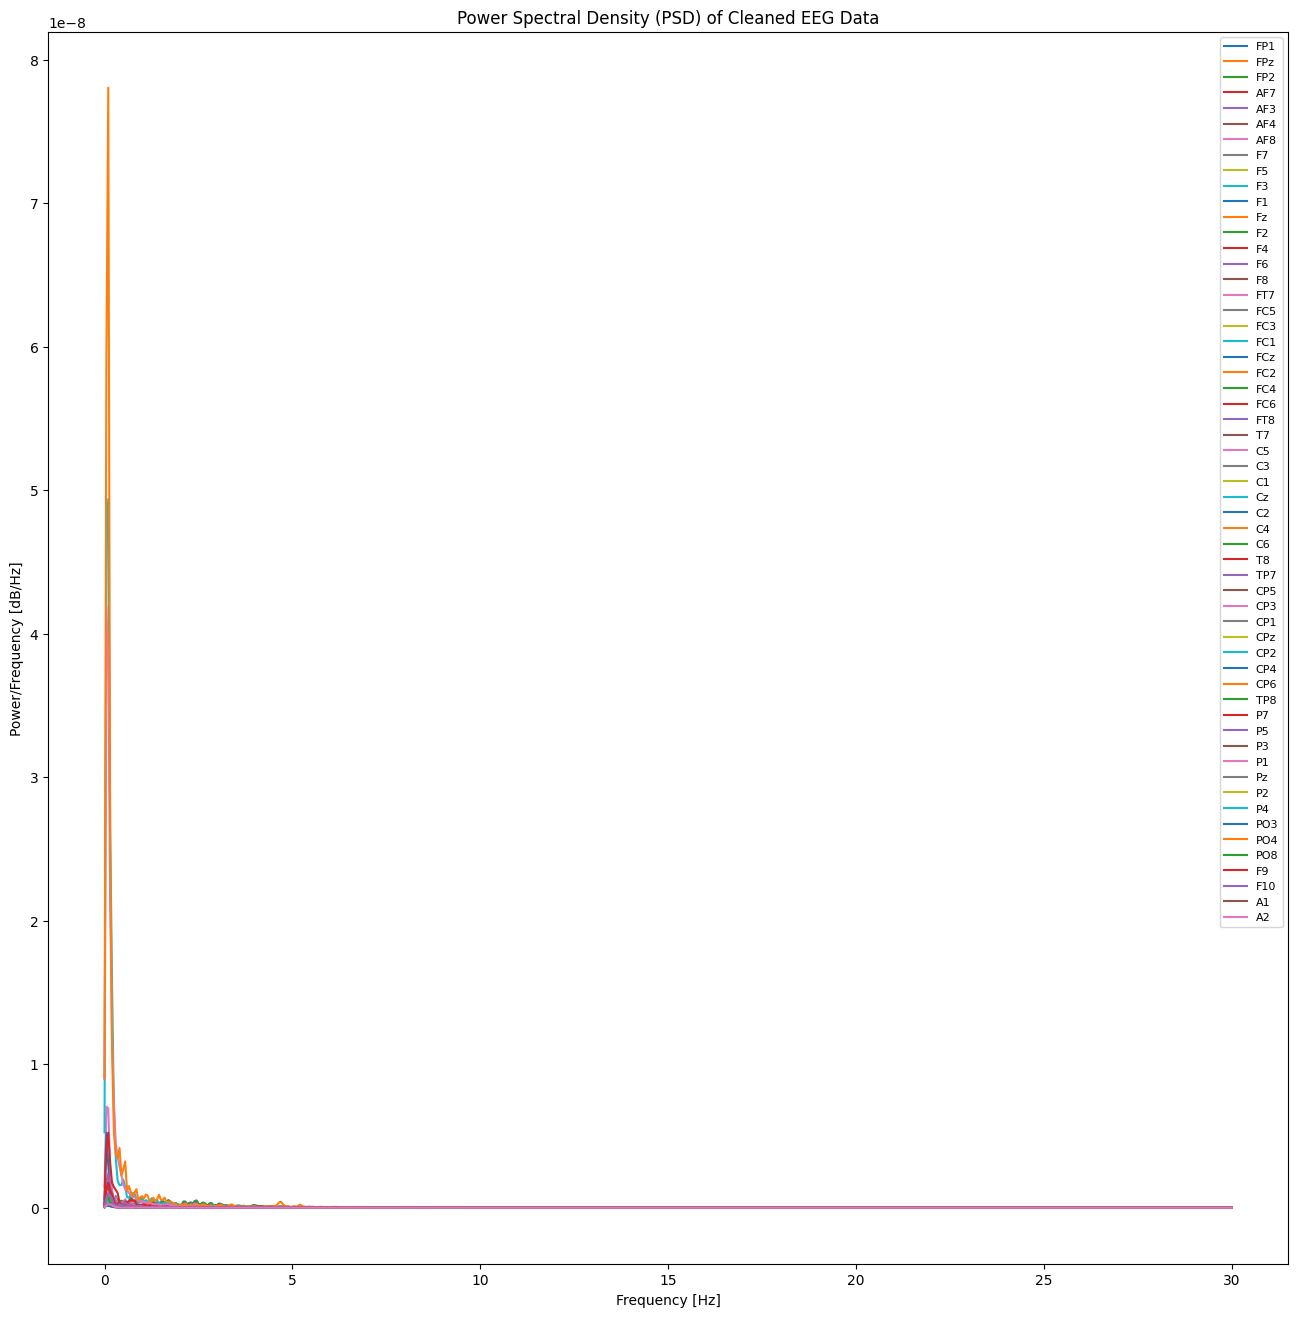

In [30]:
# Plot the all frequency band data (frequency between 0 to 4) from welch PSD using plotly express
# plot_Plotly_Express_PSD(welch_psd_df, 'Power Spectral Density (PSD) of Cleaned EEG Data', {'freq': 'Frequency [Hz]', 'value': 'Power/Frequency [dB/Hz]'})
# Plot the all frequency band data (frequency between 0 to 4) from welch PSD using pyplot
plot_PyPlot_PSD(welch_psd_df, 'Power Spectral Density (PSD) of Cleaned EEG Data', 'Frequency [Hz]', 'Power/Frequency [dB/Hz]')

### Delta Band

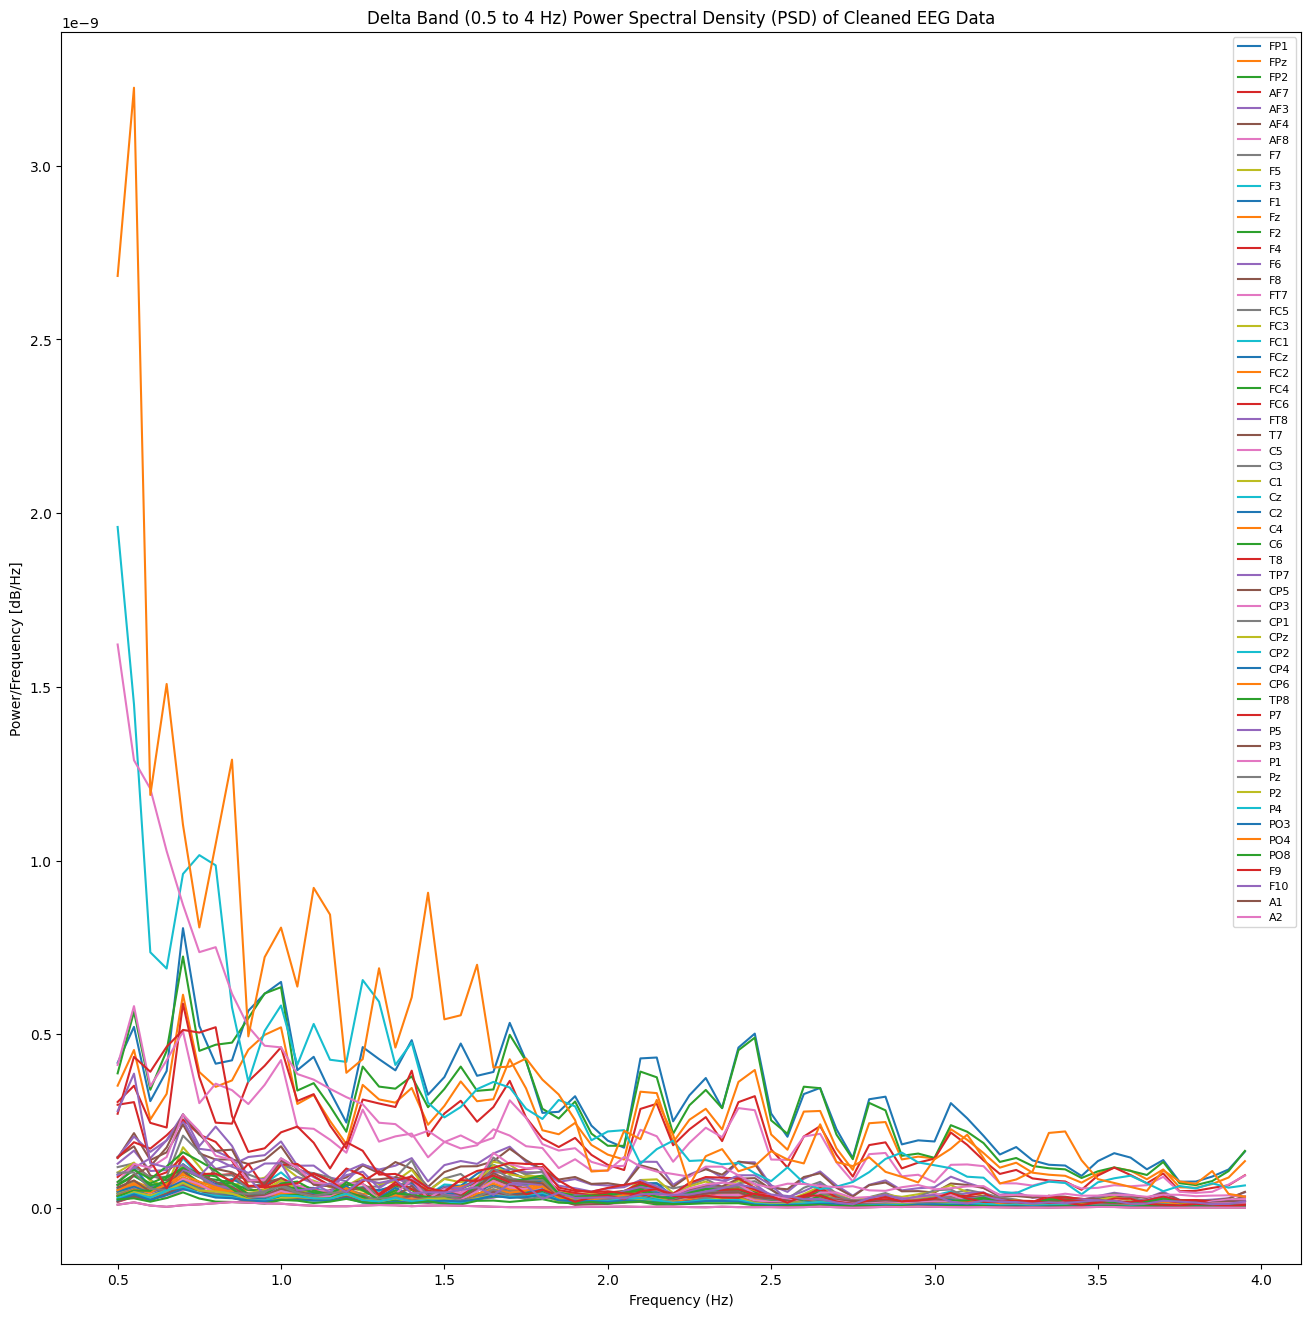

In [31]:
# Plot the delta band data (frequency between 0.5 to 4) from welch PSD using plotly express
# plot_Plotly_Express_PSD(delta_band, 'Delta Band Power Spectral Density (PSD) of Cleaned EEG Data', {'freq': 'Frequency (Hz)', 'value': 'Power/Frequency [dB/Hz]'})

# Plot the delta band data (frequency between 0.5 to 4) from welch PSD using pyplot
plot_PyPlot_PSD(delta_band, 'Delta Band (0.5 to 4 Hz) Power Spectral Density (PSD) of Cleaned EEG Data', 'Frequency (Hz)', 'Power/Frequency [dB/Hz]')

### Theta Band

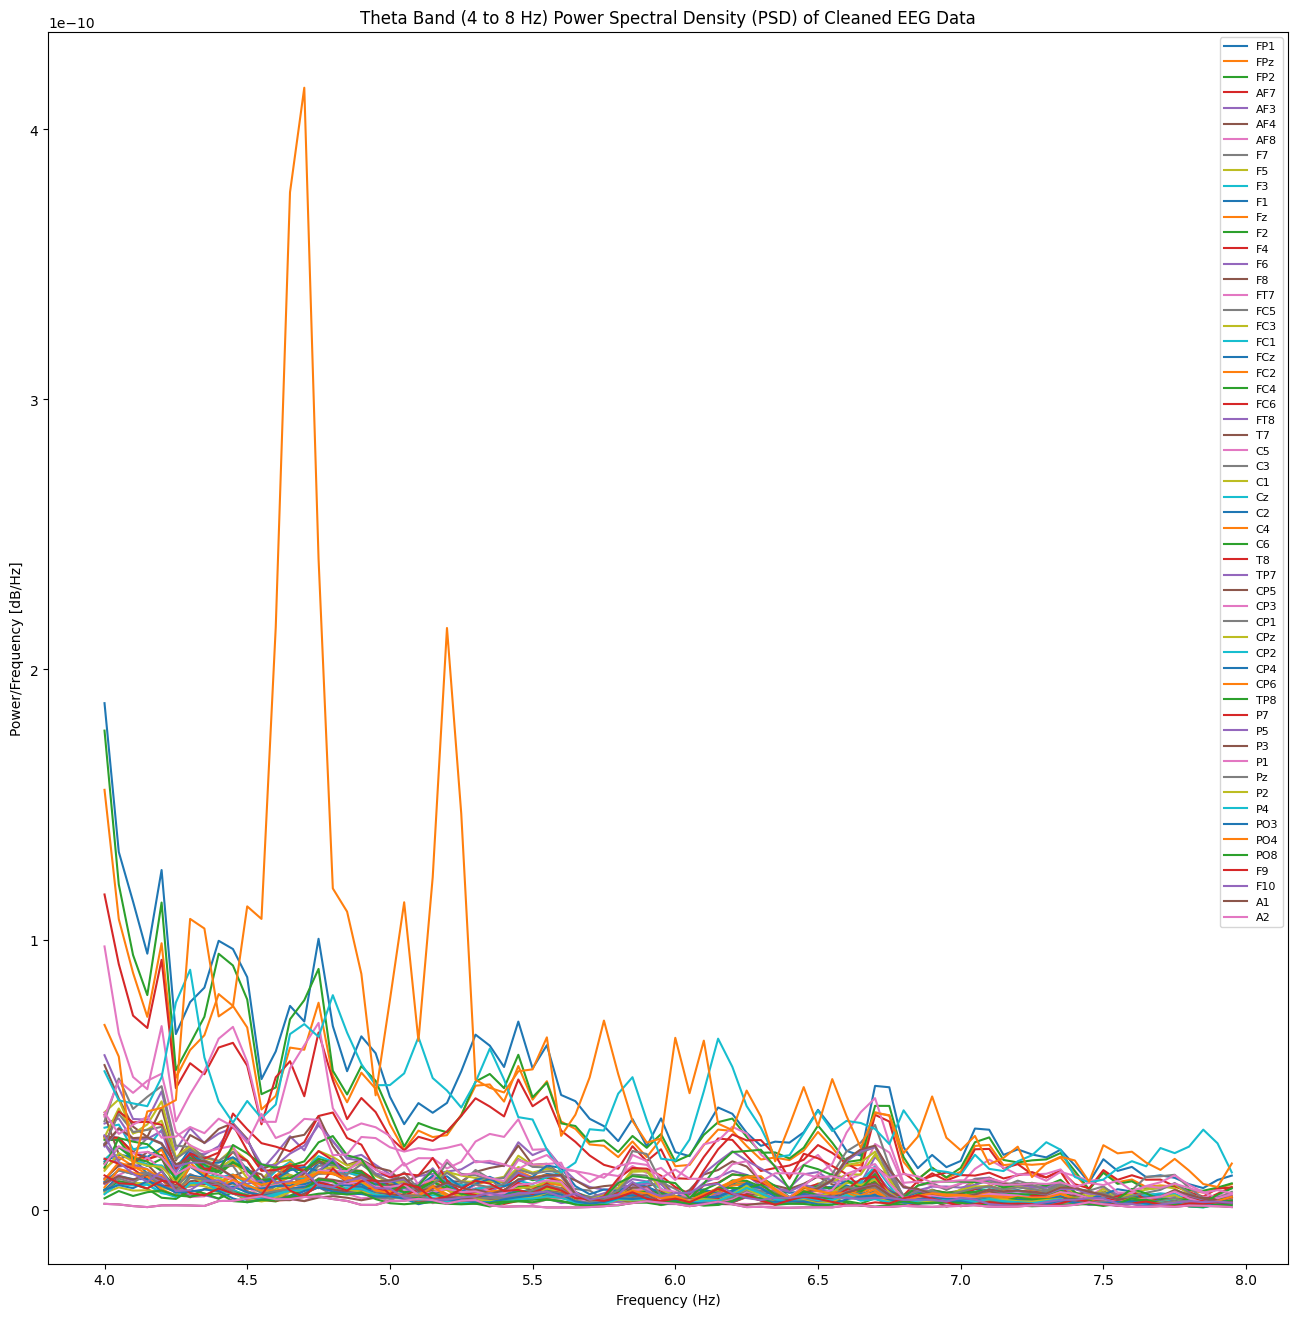

In [32]:
# Plot the theta band data (frequency between 4 to 8) from welch PSD using plotly express
# plot_Plotly_Express_PSD(theta_band, 'Theta Band Power Spectral Density (PSD) of Cleaned EEG Data', {'freq': 'Frequency (Hz)', 'value': 'Power/Frequency [dB/Hz]'})

# Plot the theta band data (frequency between 4 to 8) from welch PSD using pyplot
plot_PyPlot_PSD(theta_band, 'Theta Band (4 to 8 Hz) Power Spectral Density (PSD) of Cleaned EEG Data', 'Frequency (Hz)', 'Power/Frequency [dB/Hz]')

### Alpha Band

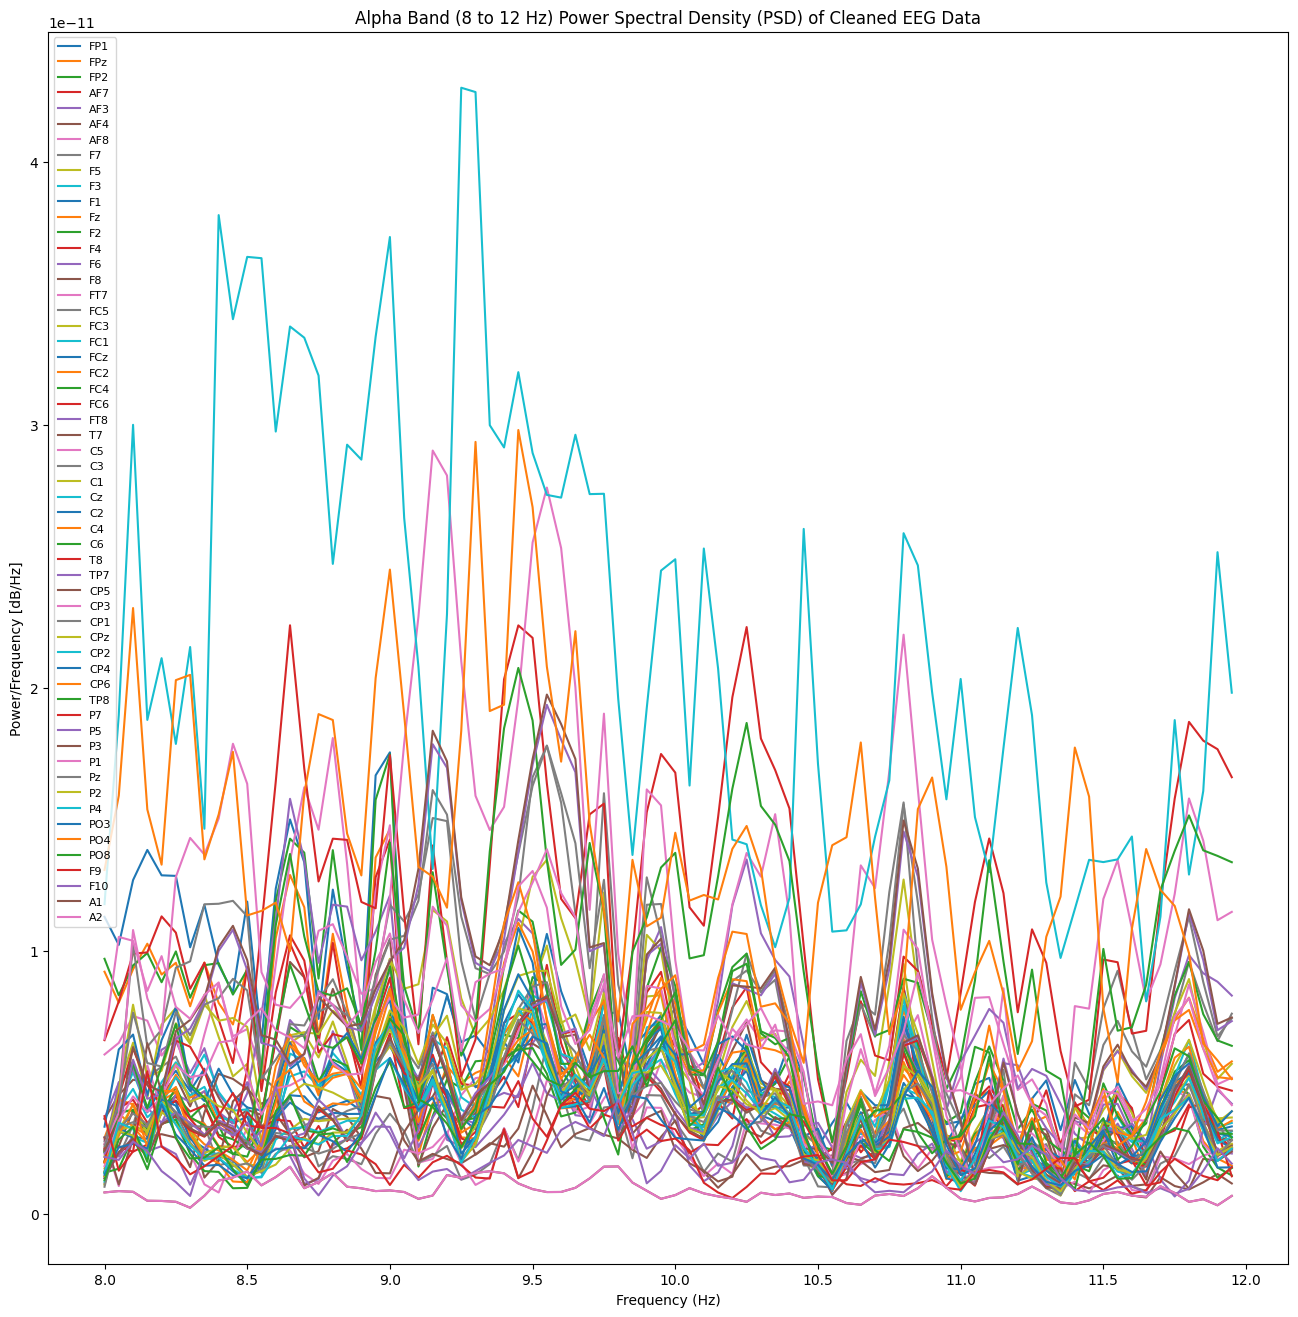

In [33]:
# Plot the alpha band data (frequency between 8 to 12) from welch PSD using plotly express
# plot_Plotly_Express_PSD(alpha_band, 'Alpha Band Power Spectral Density (PSD) of Cleaned EEG Data', {'freq': 'Frequency (Hz)', 'value': 'Power/Frequency [dB/Hz]'})
# Plot the alpha band data (frequency between 8 to 12) from welch PSD using pyplot
plot_PyPlot_PSD(alpha_band, 'Alpha Band (8 to 12 Hz) Power Spectral Density (PSD) of Cleaned EEG Data', 'Frequency (Hz)', 'Power/Frequency [dB/Hz]')

### Beta Band

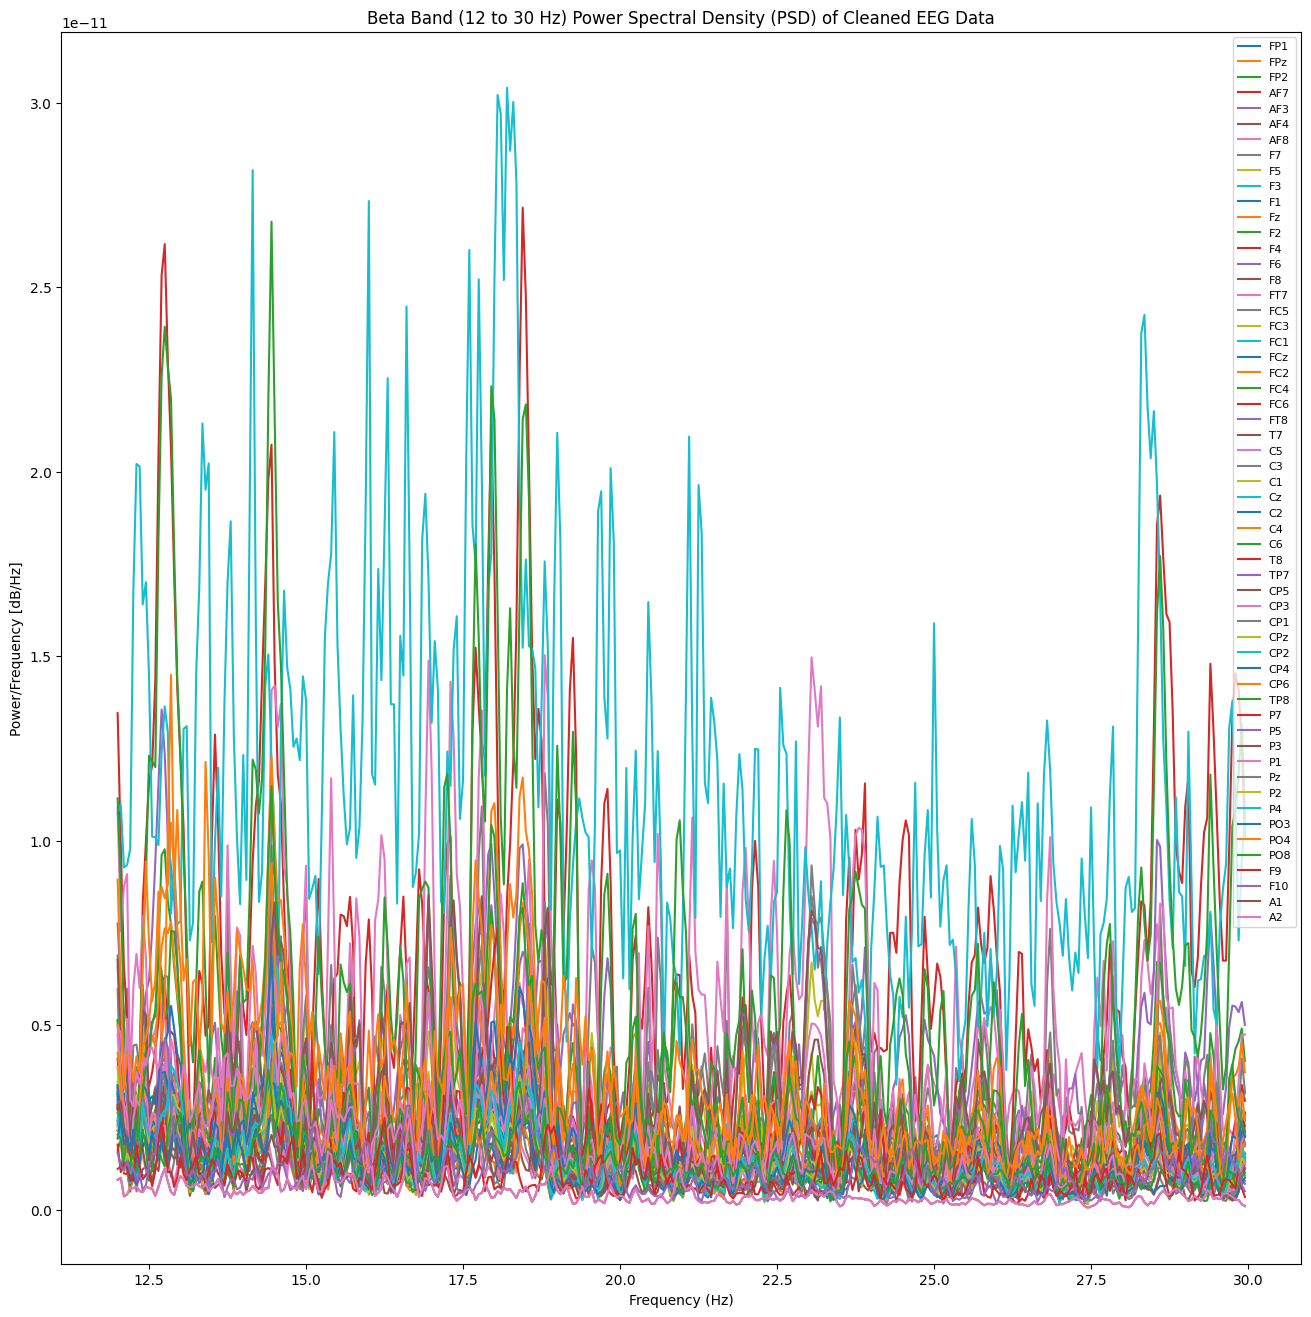

In [34]:
# Plot the beta band data (frequency between 12 to 30) from welch PSD using plotly express
# plot_Plotly_Express_PSD(beta_band, 'Beta Band Power Spectral Density (PSD) of Cleaned EEG Data', {'freq': 'Frequency (Hz)', 'value': 'Power/Frequency [dB/Hz]'})

# Plot the beta band data (frequency between 12 to 30) from welch PSD using pyplot
plot_PyPlot_PSD(beta_band, 'Beta Band (12 to 30 Hz) Power Spectral Density (PSD) of Cleaned EEG Data', 'Frequency (Hz)', 'Power/Frequency [dB/Hz]')

### Gamma Band

In [35]:
# Plot the gamma band data (frequency between > 30) from welch PSD using pyplot
# plot_Plotly_Express_PSD(welch_psd_df, 30, 120, 'Gamma Band Power Spectral Density (PSD) of Cleaned EEG Data', {'freq': 'Frequency (Hz)', 'value': 'Power/Frequency [dB/Hz]'})
# plot_PyPlot_PSD(gamma_band, 'Gamma Band Power Spectral Density (PSD) of Cleaned EEG Data', 'Frequency (Hz)', 'Power/Frequency [dB/Hz]')